<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

data_ingestion
data_ingestion
data_ingestion


2024-04-08 21:37:15,203 - data_ingestion - INFO - Database engine created successfully.
2024-04-08 21:37:15,896 - data_ingestion - INFO - Query executed successfully.
2024-04-08 21:37:15,896 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-08 21:37:15,916 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-04-08 21:37:21,438 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- C:\Users\wwaswa\Anaconda\Software\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\wwaswa\Desktop\Maji_Ndogo_Agriculture1
plugins: anyio-3.5.0, time-machine-2.13.0
collecting ... collected 0 items / 1 error

=================================== ERRORS ====================================
______________________ ERROR collecting validate_data.py ______________________
ImportError while importing test module 'C:\Users\wwaswa\Desktop\Maji_Ndogo_Agriculture1\validate_data.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
..\..\Anaconda\Software\Lib\importlib\__init__.py:126: in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
validate_data.py:4: in <module>
    from weather_data_processor import WeatherDataProcessor
E   ModuleNotFoundError: No module named 'weather_data_processor'
----

## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
* 16 predictors; Location, Soil_type, and Crop_type are categorical.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [4]:
# Your code here
dataset_use = dataset.copy()
predictors = dataset_use.drop(['Annual_yield'], axis=1)
print(predictors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Crop_type          5654 non-null   object 
 16  Standard_yield     5654 

### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID` 

#### Options
* 31
* 29
* 17
* 16

In [5]:
# Your code here
df_encoded = pd.get_dummies(dataset_use, columns=["Location", "Soil_type", "Crop_type"], drop_first =True, dtype=int)
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Field_ID                 5654 non-null   int64  
 1   Elevation                5654 non-null   float64
 2   Latitude                 5654 non-null   float64
 3   Longitude                5654 non-null   float64
 4   Slope                    5654 non-null   float64
 5   Rainfall                 5654 non-null   float64
 6   Min_temperature_C        5654 non-null   float64
 7   Max_temperature_C        5654 non-null   float64
 8   Ave_temps                5654 non-null   float64
 9   Soil_fertility           5654 non-null   float64
 10  pH                       5654 non-null   float64
 11  Pollution_level          5654 non-null   float64
 12  Plot_size                5654 non-null   float64
 13  Annual_yield             5654 non-null   float64
 14  Standard_yield          

### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* Pollution_level
* Crop_type_tea
* Annual_yield 
* Longitude 

In [6]:
# Your code here
# Calculating the correlation coefficients
correlation_matrix = df_encoded.corr()
correlation_with_target = correlation_matrix['Standard_yield'].abs().sort_values(ascending=False)

# Display the correlations with the target variable
print("Correlation of features with Standard_yield rate:\n", correlation_with_target)

Correlation of features with Standard_yield rate:
 Standard_yield             1.000000
Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Pollution_level            0.285761
Crop_type_coffee           0.222217
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Soil_type_Silt             0.205861
pH                         0.196613
Crop_type_cassava          0.186716
Crop_type_potato           0.175484
Soil_type_Sandy            0.164714
Min_temperature_C          0.144233
Soil_type_Peaty            0.135509
Elevation                  0.129248
Max_temperature_C          0.111649
Location_Rural_Hawassa     0.110623
Crop_type_rice             0.104056
Crop_type_wheat            0.092420
Longitude                  0.085343
Soil_type_Rocky            0.078355
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Location_Rural_Amanzi      0.032049
Field_ID     

### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

In [22]:
# Your code here
#The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.

### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* pH
* Soil_fertility

In [7]:
df_encoded_1 = df_encoded[['Standard_yield', 'Elevation', 'Latitude', 'Longitude', 'Slope', 'Rainfall',
       'Min_temperature_C', 'Max_temperature_C', 'Ave_temps', 'Soil_fertility',
       'pH', 'Pollution_level', 'Plot_size', 'Annual_yield', 
       'Location_Rural_Amanzi', 'Location_Rural_Hawassa',
       'Location_Rural_Kilimani', 'Location_Rural_Sokoto', 'Soil_type_Peaty',
       'Soil_type_Rocky', 'Soil_type_Sandy', 'Soil_type_Silt',
       'Soil_type_Volcanic', 'Crop_type_cassava', 'Crop_type_coffee',
       'Crop_type_maize', 'Crop_type_potato', 'Crop_type_rice',
       'Crop_type_tea', 'Crop_type_wheat']]

In [9]:
# Your code here

import statsmodels.formula.api as sm

# Regression string
formula_str = df_encoded_1.columns[0]+' ~ '+'+'.join(df_encoded_1.columns[1:]); formula_str

# Model and fitting
model=sm.ols(formula=formula_str, data=df_encoded_1)

fitted = model.fit()

print(fitted.summary())

"""
To determine which variables are statistically significant for predicting the Standard_yield,
we need to look at the p-values associated with each predictor variable. 
A p-value less than the chosen significance level (in this case, 0.05) 
indicates that the variable is statistically significant.

From the provided output, we can identify the statistically significant variables based on their p-values:

PH: p-value = 0.000 (less than 0.05)
"""

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:09:33   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

'\nTo determine which variables are statistically significant for predicting the Standard_yield,\nwe need to look at the p-values associated with each predictor variable. \nA p-value less than the chosen significance level (in this case, 0.05) \nindicates that the variable is statistically significant.\n\nFrom the provided output, we can identify the statistically significant variables based on their p-values:\n\nPH: p-value = 0.000 (less than 0.05)\n'

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* Min_temperature_C and Elevation

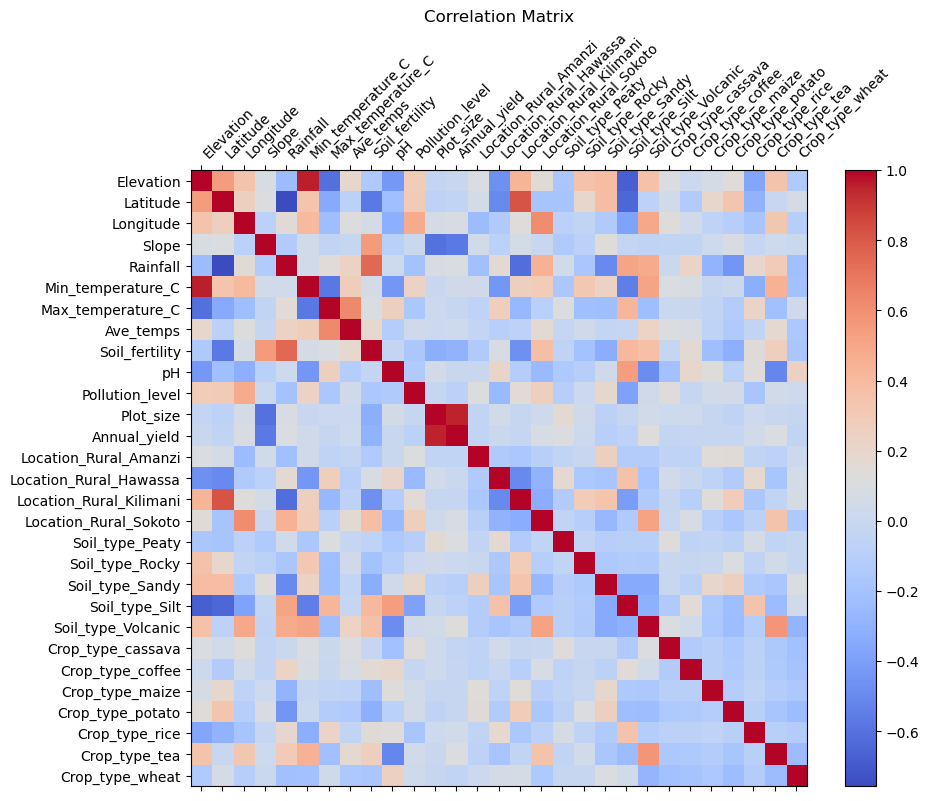

In [8]:
# Create the correlation_matrix
from statsmodels.graphics.correlation import plot_corr

def plot_corr(corr, xnames=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax)
    if xnames is not None:
        ax.set_xticks(range(len(xnames)))
        ax.set_yticks(range(len(xnames)))
        ax.set_xticklabels(xnames)
        ax.set_yticklabels(xnames)
    plt.xticks(rotation=45, ha='left')
    plt.title('Correlation Matrix')
    plt.show()

# Apply the function
corr = df_encoded_1.drop('Standard_yield', axis='columns').corr()
fig=plot_corr(corr, xnames=corr.columns, figsize=(10, 8))  # Adjustable figure size

### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [9]:
# Your code here
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Define the formula for the regression model
formula = "Standard_yield ~ " + " + ".join(df_encoded_1.drop(['Standard_yield'], axis=1).columns)

# Fit the OLS regression model
model = smf.ols(formula=formula, data=df_encoded_1).fit()

# Print the model summary
print(model.summary())

"""
The F-statistic tests the overall significance of the regression model. 
A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant,
meaning that at least one of the independent variables has a significant effect on the dependent variable.
However, when interpreting the overall significance of the regression model using the F-statistic, 
we typically refer to the p-value associated with the F-statistic itself.

In the provided summary, the p-value associated with the F-statistic is labeled as "Prob (F-statistic)"
and it's located in the second row under the "OLS Regression Results" section. 
This p-value tells us the probability of observing an F-statistic as extreme as the one calculated from our data,
under the null hypothesis that all coefficients (except the intercept) are zero simultaneously.
Therefore, when interpreting the overall significance of the regression model, we look at this p-value.
If this p-value is sufficiently small (typically less than 0.05), we reject the null hypothesis
and conclude that the regression model as a whole is statistically significant. 
In this case, it indicates that at least one of the independent variables has a significant effect 
on the dependent variable
"""

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     616.9
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:48:54   Log-Likelihood:                 8334.5
No. Observations:                5654   AIC:                        -1.661e+04
Df Residuals:                    5625   BIC:                        -1.642e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

'\nThe F-statistic tests the overall significance of the regression model. \nA high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant,\nmeaning that at least one of the independent variables has a significant effect on the dependent variable.\nHowever, when interpreting the overall significance of the regression model using the F-statistic, \nwe typically refer to the p-value associated with the F-statistic itself.\n\nIn the provided summary, the p-value associated with the F-statistic is labeled as "Prob (F-statistic)"\nand it\'s located in the second row under the "OLS Regression Results" section. \nThis p-value tells us the probability of observing an F-statistic as extreme as the one calculated from our data,\nunder the null hypothesis that all coefficients (except the intercept) are zero simultaneously.\nTherefore, when interpreting the overall significance of the regression model, we look at this p-value.\nIf this 

### Question 8 

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* The model worsened.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [10]:
df_encoded_1.columns

Index(['Standard_yield', 'Elevation', 'Latitude', 'Longitude', 'Slope',
       'Rainfall', 'Min_temperature_C', 'Max_temperature_C', 'Ave_temps',
       'Soil_fertility', 'pH', 'Pollution_level', 'Plot_size', 'Annual_yield',
       'Location_Rural_Amanzi', 'Location_Rural_Hawassa',
       'Location_Rural_Kilimani', 'Location_Rural_Sokoto', 'Soil_type_Peaty',
       'Soil_type_Rocky', 'Soil_type_Sandy', 'Soil_type_Silt',
       'Soil_type_Volcanic', 'Crop_type_cassava', 'Crop_type_coffee',
       'Crop_type_maize', 'Crop_type_potato', 'Crop_type_rice',
       'Crop_type_tea', 'Crop_type_wheat'],
      dtype='object')

In [11]:
# Your code here

import statsmodels.api as sm
import statsmodels.formula.api as smf

df_encoded_1_imp = df_encoded_1[['Standard_yield', 'Pollution_level', 'Crop_type_coffee', 
                                 'Location_Rural_Sokoto', 'Annual_yield', 'Soil_type_Silt','Soil_type_Volcanic']]


# Define the formula for the regression model
formula = "Standard_yield ~ " + " + ".join(df_encoded_1_imp.drop(['Standard_yield'], axis=1).columns)

# Fit the OLS regression model
model_imp = smf.ols(formula=formula, data=df_encoded_1).fit()

# Print the model summary
print(model_imp.summary())

"""
After reducing the number of predictor variables, the following changes are observed:

-The R-squared value decreased from 0.756 to 0.348.
-The Adjusted R-squared value also decreased from 0.755 to 0.347.
-The F-statistic decreased from 623.8 to 501.5.
-The AIC (Akaike Information Criterion) increased from -16660 to -11130.
-The BIC (Bayesian Information Criterion) increased from -16470 to -11090.
-These changes suggest that the model performance has worsened after reducing the number of predictor variables. 
    The model is explaining less of the variance in the dependent variable and likely experiencing overfitting, 
    as indicated by the increases in AIC and BIC.

Therefore, the correct option is:

"The model worsened."
"""

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     501.5
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:49:00   Log-Likelihood:                 5573.3
No. Observations:                5654   AIC:                        -1.113e+04
Df Residuals:                    5647   BIC:                        -1.109e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.57

'\nAfter reducing the number of predictor variables, the following changes are observed:\n\n-The R-squared value decreased from 0.756 to 0.348.\n-The Adjusted R-squared value also decreased from 0.755 to 0.347.\n-The F-statistic decreased from 623.8 to 501.5.\n-The AIC (Akaike Information Criterion) increased from -16660 to -11130.\n-The BIC (Bayesian Information Criterion) increased from -16470 to -11090.\n-These changes suggest that the model performance has worsened after reducing the number of predictor variables. \n    The model is explaining less of the variance in the dependent variable and likely experiencing overfitting, \n    as indicated by the increases in AIC and BIC.\n\nTherefore, the correct option is:\n\n"The model worsened."\n'

### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

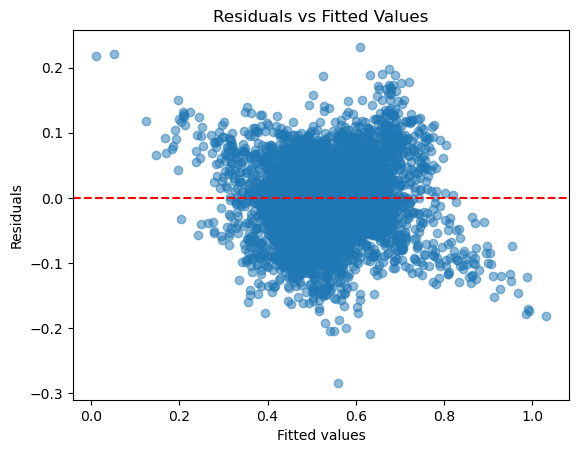

In [12]:
#Your code here
import matplotlib.pyplot as plt

# Get the residuals
residuals = model.resid

# Get the fitted values
fitted_values = model.fittedvalues

# Create scatter plot
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.show()

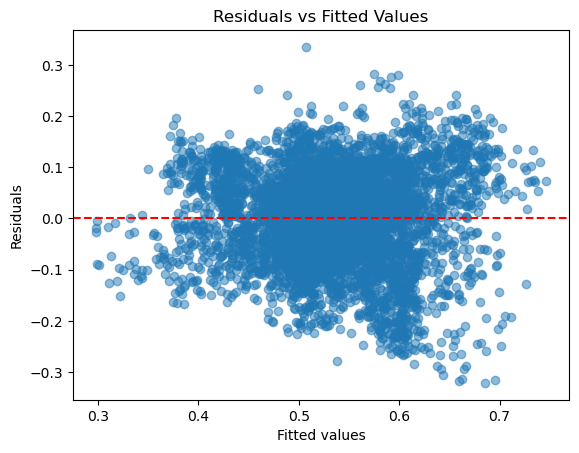

In [13]:
#Your code here
import matplotlib.pyplot as plt

# Get the residuals
residuals = model_imp.resid

# Get the fitted values
fitted_values = model_imp.fittedvalues

# Create scatter plot
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.show()

**NOTES ON HOMOSKEDASTICITY VS HETEROSKEDASTICITY**  

"""
Interpret the scatter plot:

-If the residuals have constant variance and are distributed randomly around the zero residual line,
    it suggests that the assumptions of homoscedasticity and randomness of errors are met.
-If there is a clear pattern or structure in the scatter plot (e.g., funnel shape, heteroscedasticity), 
    it indicates that the model's residuals violate the assumption of constant variance, 
    which might require further investigation or model refinement.
-By visually inspecting the scatter plot, we can assess whether the model's residuals behave as expected
    and whether the model assumptions are met.


-HOMOSCEDASTICITY:

Random scatter around the zero line: You would see the residuals spread out evenly above and below the zero line 
without any clear pattern. This indicates that the variance of the residuals is consistent across all levels of the fitted values.

No discernible pattern: The points in the scatter plot should not form any specific pattern or trend. 
If you observe a clear trend (e.g., residuals systematically increasing or decreasing as the fitted values change), 
it suggests heteroscedasticity, indicating that the variance of residuals varies with the fitted values.

Constant spread across fitted values: The spread or dispersion of the residuals should remain roughly 
consistent across all levels of the fitted values. In other words, the width of the scatter 
should be approximately constant along the horizontal axis.

If you observe these characteristics in the scatter plot of residuals against fitted values,
it suggests that the assumption of homoscedasticity is reasonable, indicating that the variance of the residuals 
is consistent across the range of predicted values.

HETEROSKEDASTICITY:

Heteroscedasticity in the residuals vs. fitted values plot would manifest as a discernible pattern 
or trend in the scatter of residuals around the zero line. Here's how heteroscedasticity would appear in such a plot:

Non-Constant Spread: Unlike homoscedasticity, where the spread of residuals is approximately consistent across all levels of fitted values,
heteroscedasticity exhibits a varying spread. This means that the width or dispersion of the scatter
of residuals changes as the fitted values increase or decrease.

Fan-Shaped Pattern: Heteroscedasticity often presents as a fan-shaped or cone-shaped pattern in the scatter plot. 
This indicates that the variance of residuals systematically increases or decreases as the fitted values change. 
For example, the spread of residuals might widen as the fitted values increase or vice versa.

Trend in Residuals: In addition to the changing spread, there might be a discernible trend in the residuals 
as the fitted values change. This trend could be upward or downward, indicating that the variability 
of the dependent variable increases or decreases across different levels of the independent variables.

Violation of Homoscedasticity Assumption: Heteroscedasticity violates the assumption of constant variance of residuals, 
which is essential for the validity of many statistical tests and estimators. 
It indicates that the errors of the model are not uniformly distributed and may lead to biased parameter estimates 
and incorrect inference.

In summary, heteroscedasticity in the residuals vs. fitted values plot is characterized by a non-constant spread 
of residuals and a discernible pattern or trend in the scatter, indicating that the variability of the dependent variable 
changes systematically across different levels of the independent variables.
"""

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* All of the above.

In [23]:
#All of the above.

## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [14]:
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

dataset_use['Temperature_Range'] = dataset_use['Max_temperature_C'] - dataset_use['Min_temperature_C']


dataset_use.head(2)

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield,Unnamed: 0,Temperature_Range
0,40734,786.0558,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964,0,36.2
1,30629,674.3341,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302,1,34.5


In [15]:
from sklearn.preprocessing import StandardScaler

# Insert selected option here

#dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [16]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

"""
The purpose of the LassoCV(cv=5) constructor parameter cv=5 is:

Option 1: It indicates that 5-fold cross-validation should be used to select the best regularization parameter.

Explanation:

In Lasso regression, the regularization parameter (alpha) controls the strength of regularization.
cv=5 specifies that 5-fold cross-validation should be used.
During the cross-validation process, the data is split into 5 folds. The model is trained on 
4 folds and validated on the remaining fold, repeated 5 times,
with each fold being used as the validation set exactly once.
The purpose of cross-validation in this context is to select the best value for the regularization parameter alpha.
By trying different values of alpha and evaluating their performance using cross-validation, 
the model can choose the alpha that minimizes prediction error, thereby helping to prevent overfitting.
Therefore, the correct option is:

It indicates that 5-fold cross-validation should be used to select the best regularization parameter.
"""

'\nThe purpose of the LassoCV(cv=5) constructor parameter cv=5 is:\n\nOption 1: It indicates that 5-fold cross-validation should be used to select the best regularization parameter.\n\nExplanation:\n\nIn Lasso regression, the regularization parameter (alpha) controls the strength of regularization.\ncv=5 specifies that 5-fold cross-validation should be used.\nDuring the cross-validation process, the data is split into 5 folds. The model is trained on \n4 folds and validated on the remaining fold, repeated 5 times,\nwith each fold being used as the validation set exactly once.\nThe purpose of cross-validation in this context is to select the best value for the regularization parameter alpha.\nBy trying different values of alpha and evaluating their performance using cross-validation, \nthe model can choose the alpha that minimizes prediction error, thereby helping to prevent overfitting.\nTherefore, the correct option is:\n\nIt indicates that 5-fold cross-validation should be used to se

### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`
* `scoring='neg_mean_squared_error`

In [17]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)` 
* `poly = PolynomialFeatures(degree=1, include_bias=False)` 
* `poly = PolynomialFeatures(degree=3, include_bias=True)` 
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
#Insert selected option here
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)

### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

In [19]:
"""
Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.
"""
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_

array([-0.13661379,  0.10262221, -0.07348657])

## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* 0.48494414
* 0.8050340

In [20]:
# Your code here
df_encoded_1.columns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Splitting the dataset into independent and dependent variables
# X should contain all features except 'Standard_yield' and 'Field_ID'
X = df_encoded_1.drop(['Standard_yield'], axis=1)
y = df_encoded_1['Standard_yield']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the Decision Tree Regressor model
max_depth = 2
random_state = 42
dt_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
dt_regressor.fit(X_train, y_train)

# Making predictions
x_values = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, 
            -3.4100000000000006, 36.410000000000004, 16.5,0.682, 6.7863323423108195, 0.09379352739936421, 
            1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]
predicted_y = dt_regressor.predict([x_values])

print("Predicted y value:", predicted_y)

Predicted y value: [0.48522637]


C:\Users\wwaswa\Anaconda\Software\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* 0.0881
* 0.5656
* 0.8810

In [21]:
# Your code here
from sklearn.metrics import mean_squared_error

# Predicting on the testing data
y_pred = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)

RMSE: 0.08817759042404145


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

**Answer Q18   

"An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units."

### Question 19 
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.



Answer Q19  

Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.


### Question 20 
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* True
* False

Ans Q20  
True due to lower RMSE


## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21 
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# MISSING PART HERE
bagged_predictions = np.mean(predictions, axis=0)
mse_bagged = mean_squared_error(y, bagged_predictions)


print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.010840494255588572


Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)` 

### Question 22 

Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

#### Options
* `max_depth`
* `random_state`
* `max_features`
* `n_estimators`

Ans Q22:
The parameter in the RandomForestRegressor constructor that is crucial for implementing the random 
subspace method by allowing the algorithm to select a random subset of features for each split is:

max_features

The max_features parameter determines the maximum number of features to consider when looking 
for the best split at each node. By setting max_features to a value less than the total number of features, 
RandomForestRegressor will randomly select a subset of features for consideration at each split, 
effectively implementing the random subspace method. This helps introduce randomness into the decision trees,
reducing correlation among trees and improving the overall performance of the random forest model.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.0011087288427960044


### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`
* `lin`
* `sigmoid`
* `degree=1`

In [27]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
#ANS Q24: scoring='neg_mean_squared_error', cv=5
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [29]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.32010523510764793
Feature: Slope, Importance: 0.2192517169338995
Feature: Soil_fertility, Importance: 0.15419324948595828
Feature: Pollution_level, Importance: 0.3064497984724943


Ans Q25:    
The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* R2: 0.9586, MSE: 0.0006
* R2: 0.8196, MSE: 0.0500

In [30]:
#Your code here
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def train_rf_model(model, dataset):
    # Separate features (X) and target (y)
    X = dataset.drop('Standard_yield', axis=1)
    y = dataset['Standard_yield']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate R-squared score
    r_squared = r2_score(y_test, y_pred)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return model, r_squared, mse


In [31]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor with specified hyperparameters
rf_model = RandomForestRegressor(random_state=42, max_depth=15)

# Train the random forest model using the train_rf_model function
trained_rf_model, r_squared, mse = train_rf_model(rf_model, df_encoded_1)

print("R-squared score:", r_squared)
print("Mean Squared Error (MSE):", mse)

R-squared score: 0.958985544262812
Mean Squared Error (MSE): 0.0005465351029774748


### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* There was no change in the error.

Ans Q27:  
The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.

In [32]:
#Your code here
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into features (X) and target (y)
X = df_encoded_1.drop('Standard_yield', axis=1)
y = df_encoded_1['Standard_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the first random forest model with 150 trees
rf_model_150 = RandomForestRegressor(n_estimators=150, random_state=42)
rf_model_150.fit(X_train, y_train)

# Make predictions with the first model
y_pred_150 = rf_model_150.predict(X_test)

# Calculate Mean Squared Error (MSE) for the first model
mse_150 = mean_squared_error(y_test, y_pred_150)

# Train the second random forest model with 200 trees
rf_model_200 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model_200.fit(X_train, y_train)

# Make predictions with the second model
y_pred_200 = rf_model_200.predict(X_test)

# Calculate Mean Squared Error (MSE) for the second model
mse_200 = mean_squared_error(y_test, y_pred_200)

print("Mean Squared Error (MSE) with 150 trees:", mse_150)
print("Mean Squared Error (MSE) with 200 trees:", mse_200)


Mean Squared Error (MSE) with 150 trees: 0.000493199675905726
Mean Squared Error (MSE) with 200 trees: 0.0004919766758480172


### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

Ans Q28:  
Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.

### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* Rainfall, Crop_type_tea, Latitude
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [33]:
#Your code here
# Access the feature importances from the model trained with 200 trees
feature_importances_200 = rf_model_200.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_200})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 3 most significant features
importance_df.head(3)

,Feature,Importance
4,Rainfall,0.203345
27,Crop_type_tea,0.182603
1,Latitude,0.154068


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

Ans Q30:  
RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>